In [ ]:
import dvc.api
import pandas as pd
# reading dataset
with dvc.api.open("data/creditcard.csv", repo = "https://github.com/raja-7-c/MLOps_Assignment") as fd:
    df = pd.read_csv(fd)

In [2]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
data_unseen = df.sample(frac=0.1, random_state=67)      # Sample 10% of the data to become the unseen test set
data = df.drop(data_unseen.index)                       # Use the remaining 90% as the training (& validation) data

data.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Model Training & Validation: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Model Training & Validation: (256326, 31)
Unseen Data For Predictions: (28481, 31)


In [4]:
df1 = pd.DataFrame(data_unseen)
df1.to_csv("../data/test.csv")

In [5]:
from pycaret.classification import *

In [6]:
import mlflow

In [7]:
expt2_pycaret = setup(
    data = df, 
    log_experiment = True,
    experiment_name = 'Credit Card Fraud - Expt 2' ,
    log_plots = True,
    target = 'Class', 
    session_id=12345,                      # Random seed to ensure reproducibility of the experiment with the same data
    train_size=0.8,                     # 80% training data & 20% held-out validation data
    ignore_features=["Time"],
    normalize = True,
                   transformation = True,
                   normalize_method = "minmax",
                   polynomial_features=True,
                   trigonometry_features=True,
    numeric_imputation="median",        # "mean" by default
    categorical_imputation="mode",      # "constant" (not_available) by default
)

,Description,Value
0,session_id,12345
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(284807, 31)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [8]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [9]:
top2 = compare_models(sort ='F1',fold = 5,exclude = ["rf","et","ada","knn","gbc"],n_select = 2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.9994,0.8979,0.7861,0.8422,0.8130,0.8126,0.8132,0.9580
lr,Logistic Regression,0.9993,0.9800,0.7313,0.8671,0.7931,0.7927,0.7958,2.1160
dt,Decision Tree Classifier,0.9990,0.8642,0.7289,0.7204,0.7244,0.7239,0.7240,7.9320
svm,SVM - Linear Kernel,0.9991,0.0000,0.5822,0.8653,0.6951,0.6947,0.7089,0.3040
ridge,Ridge Classifier,0.9990,0.0000,0.5424,0.8636,0.6658,0.6654,0.6837,0.1960
lightgbm,Light Gradient Boosting Machine,0.9962,0.7588,0.6294,0.2677,0.3729,0.3714,0.4071,2.2660
qda,Quadratic Discriminant Analysis,0.9853,0.9688,0.8607,0.0954,0.1717,0.1691,0.2837,1.0800
nb,Naive Bayes,0.9780,0.9639,0.8409,0.0639,0.1187,0.1158,0.2282,0.6960


In [10]:
for model in top2:
    print(model)
    print()

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)



In [11]:
lda = top2[0]
tuned_lda = tune_model(lda,optimize='AUC',n_iter=30,fold=6)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9992,0.8871,0.7313,0.8167,0.7717,0.7713,0.7725
1,0.9995,0.9161,0.7910,0.8983,0.8413,0.8410,0.8427
2,0.9996,0.9618,0.8955,0.8955,0.8955,0.8953,0.8953
3,0.9991,0.8573,0.6716,0.8036,0.7317,0.7313,0.7342
4,0.9992,0.8798,0.7463,0.7937,0.7692,0.7688,0.7692
5,0.9994,0.9393,0.8358,0.8485,0.8421,0.8418,0.8419
Mean,0.9994,0.9069,0.7786,0.8427,0.8086,0.8083,0.8093
SD,0.0002,0.0359,0.0728,0.0419,0.0556,0.0557,0.0550


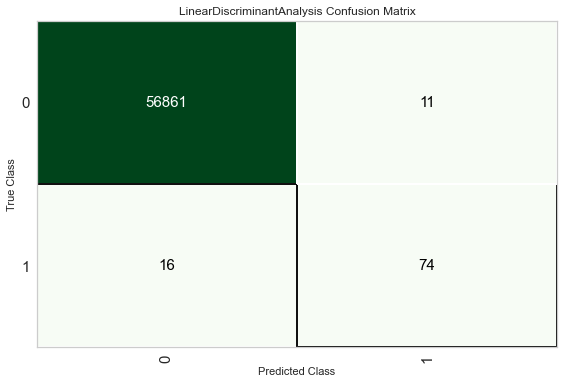

In [12]:
plot_model(tuned_lda, plot="confusion_matrix")

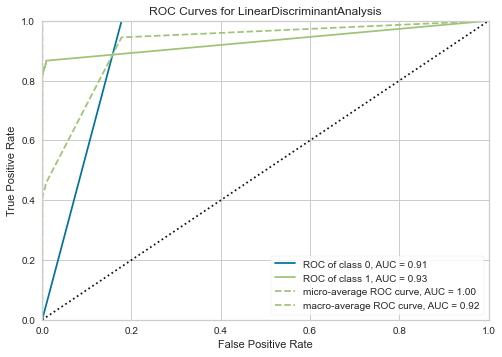

In [13]:
plot_model(tuned_lda, plot="auc")

In [14]:
lr = top2[1]
tuned_lr = tune_model(lr,optimize='F1',n_iter =30,fold =6)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9993,0.9812,0.7313,0.8596,0.7903,0.7900,0.7926
1,0.9994,0.9812,0.7164,0.9057,0.8000,0.7997,0.8052
2,0.9995,0.9893,0.7910,0.8983,0.8413,0.8410,0.8427
3,0.9991,0.9712,0.6269,0.8235,0.7119,0.7114,0.7181
4,0.9993,0.9696,0.7313,0.8305,0.7778,0.7774,0.7790
5,0.9994,0.9859,0.8060,0.8571,0.8308,0.8305,0.8309
Mean,0.9993,0.9797,0.7338,0.8625,0.7920,0.7917,0.7947
SD,0.0001,0.0072,0.0581,0.0309,0.0421,0.0421,0.0405


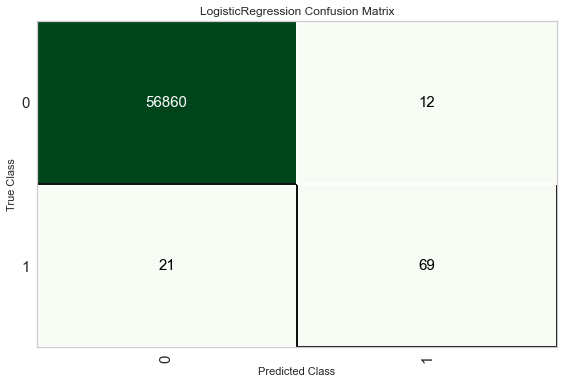

In [15]:
plot_model(tuned_lr, plot="confusion_matrix")

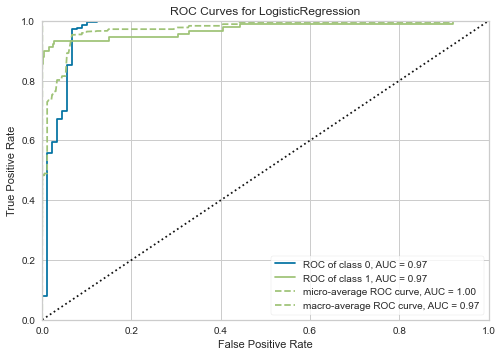

In [16]:
plot_model(tuned_lr, plot="auc")

In [17]:
predict_model(tuned_lr);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.9994,0.9708,0.7667,0.8519,0.8070,0.8067,0.8079


In [18]:
predict_model(tuned_lda);

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Linear Discriminant Analysis,0.9995,0.9324,0.8222,0.8706,0.8457,0.8455,0.8458


In [19]:
save_model(tuned_lr,'../models/tuned_lr')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Time'], id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('dfs', 'passthrough'), ('pca', 'passthrough'),
                 ['trained_model',
                  LogisticRegression(C=1.608, class_weight={}, dual=False,
                

In [20]:
save_model(tuned_lda,'../models/tuned_lda')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['Time'], id_columns=[],
                                       ml_usecase='classification',
                                       numerical_features=[], target='Class',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='most frequent',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 numeric_s...
                 ('dummy', Dummify(target='Class')),
                 ('fix_perfect', Remove_100(target='Class')),
                 ('clean_names', Clean_Colum_Names()),
                 ('feature_select', 'passthrough'), ('fix_multi', 'passthrough'),
                 ('df

In [21]:
saved_model1 = load_model('../models/tuned_lr')


Transformation Pipeline and Model Successfully Loaded


In [22]:
expt2_pycaret = setup(
    data = df, 
    log_experiment = True,
    experiment_name = 'Credit Card Fraud - Expt 2' ,
    log_plots = True,
    target = 'Class', 
    session_id=12345,                      # Random seed to ensure reproducibility of the experiment with the same data
    train_size=0.8,                     # 80% training data & 20% held-out validation data
    ignore_features=["Time"],
    normalize = True,
                   transformation = True,
                   normalize_method = "minmax",
                   polynomial_features=True,
                   trigonometry_features=True,
    numeric_imputation="median",        # "mean" by default
    categorical_imputation="mode",      # "constant" (not_available) by default
)

,Description,Value
0,session_id,12345
1,Target,Class
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(284807, 31)"
5,Missing Values,False
6,Numeric Features,29
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [23]:
final_lr = finalize_model(tuned_lr)

In [24]:
final_lr

LogisticRegression(C=1.608, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=12345, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [25]:
saved_model2 = load_model('../models/tuned_lda')


Transformation Pipeline and Model Successfully Loaded


In [26]:
final_lda = finalize_model(tuned_lda)

In [27]:
final_lda

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=1,
                           solver='lsqr', store_covariance=False, tol=0.0001)

In [ ]:
# Deploy model

deploy_model(model = final_lda, model_name = 'lda_deployed', platform = 'aws', authentication = {'bucket' : 'mlopsdvc190110070'})


In [29]:
# Deploy model

deploy_model(model = final_lr, model_name = 'lr_deployed', platform = 'aws', authentication = {'bucket' : 'mlopsdvc190110070'})


Model Successfully Deployed on AWS S3


In [30]:
loaded_model = load_model('lr_deployed', platform = 'aws', authentication = { 'bucket' : 'mlopsdvc190110070' })
predictions = predict_model(loaded_model, data=data_unseen)

predictions.head()    # View some of the predictions

Transformation Pipeline and Model Successfully Loaded


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Label,Score
0,43690.0,-0.365470,1.135745,0.559053,0.825033,-0.075053,-0.241468,0.476817,0.348927,-1.126417,...,-0.020139,0.039827,-0.063556,-0.330275,-0.055635,-0.026071,52.95,0,0,1.0000
1,3206.0,1.369826,-0.648799,0.775064,-0.623017,-1.413876,-0.871334,-0.863948,-0.098142,-0.461015,...,-0.083901,0.406365,0.428664,-0.103939,0.020707,0.022842,20.80,0,0,1.0000
2,127812.0,-1.471095,-1.756609,0.092952,0.620970,2.582357,-2.545303,-0.997943,0.113448,0.594585,...,0.496551,-0.156887,-0.642113,-0.428779,0.077807,0.188656,14.74,0,0,0.9995
3,82602.0,-0.957595,1.135317,1.210147,0.004834,-0.104034,-0.114190,0.306693,0.526946,-0.623398,...,-0.137039,0.066901,0.060114,0.240107,0.192748,0.093429,18.45,0,0,1.0000
4,68856.0,-0.355728,-0.015916,1.050436,-1.914252,0.206510,-0.888832,0.816460,-0.299490,-1.604242,...,-0.005173,-0.058543,-0.228264,-0.679666,-0.110028,-0.104781,48.98,0,0,1.0000


In [31]:
loaded_model = load_model('lda_deployed', platform = 'aws', authentication = { 'bucket' : 'mlopsdvc190110070' })
predictions = predict_model(loaded_model, data=data_unseen)

predictions.head()    # View some of the predictions

Transformation Pipeline and Model Successfully Loaded


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Label,Score
0,43690.0,-0.365470,1.135745,0.559053,0.825033,-0.075053,-0.241468,0.476817,0.348927,-1.126417,...,-0.020139,0.039827,-0.063556,-0.330275,-0.055635,-0.026071,52.95,0,0,1.0
1,3206.0,1.369826,-0.648799,0.775064,-0.623017,-1.413876,-0.871334,-0.863948,-0.098142,-0.461015,...,-0.083901,0.406365,0.428664,-0.103939,0.020707,0.022842,20.80,0,0,1.0
2,127812.0,-1.471095,-1.756609,0.092952,0.620970,2.582357,-2.545303,-0.997943,0.113448,0.594585,...,0.496551,-0.156887,-0.642113,-0.428779,0.077807,0.188656,14.74,0,0,1.0
3,82602.0,-0.957595,1.135317,1.210147,0.004834,-0.104034,-0.114190,0.306693,0.526946,-0.623398,...,-0.137039,0.066901,0.060114,0.240107,0.192748,0.093429,18.45,0,0,1.0
4,68856.0,-0.355728,-0.015916,1.050436,-1.914252,0.206510,-0.888832,0.816460,-0.299490,-1.604242,...,-0.005173,-0.058543,-0.228264,-0.679666,-0.110028,-0.104781,48.98,0,0,1.0


In [ ]:
!mlflow ui